In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
# Load the DataFrame
df = pd.read_csv("./data.csv")

# 1. Clean the 'toponym' column: convert to string, strip whitespace, convert to lowercase
df['toponym'] = df['toponym'].astype(str).str.strip().str.lower()

# 2. Convert each toponym string into a list of tokens, adding <S> and <E>
#    Each character will be a separate token
#    We create a new column 'toponym_tokens' to store these lists
df['toponym_tokens'] = df['toponym'].apply(lambda x: ['<S>'] + list(x) + ['<E>'])

# Get the unique toponym token lists (as a list of lists)
# Note: df.unique() on a column of lists won't work directly because lists are unhashable.
# We convert lists to tuples temporarily to make them hashable for unique(), then back to lists.
unique_toponym_token_tuples = df['toponym_tokens'].apply(tuple).unique()

# Convert back to list of lists for display if desired
unique_toponym_token_lists = [list(t) for t in unique_toponym_token_tuples]


# Print the list of unique toponym token lists
print("Unique Toponym Tokens (stripped, lowercased, with <S>/<E>):")
for tokens_list in unique_toponym_token_lists:
    print(tokens_list)
    break

# Display the head of the modified DataFrame to show the new 'toponym_tokens' column
print("\nDataFrame Head (with 'toponym_tokens' column):")
print(df.head())

Unique Toponym Tokens (stripped, lowercased, with <S>/<E>):
['<S>', 'f', 'r', 'a', 'n', 'c', 'e', '<E>']

DataFrame Head (with 'toponym_tokens' column):
                 toponym                                     toponym_tokens
0                 france                       [<S>, f, r, a, n, c, e, <E>]
1  france métropolitaine  [<S>, f, r, a, n, c, e,  , m, é, t, r, o, p, o...
2     france d'outre-mer  [<S>, f, r, a, n, c, e,  , d, ', o, u, t, r, e...
3  france métropolitaine  [<S>, f, r, a, n, c, e,  , m, é, t, r, o, p, o...
4       pays de la loire  [<S>, p, a, y, s,  , d, e,  , l, a,  , l, o, i...


In [132]:
# Now, let's find all unique characters and special tokens used across all tokenized toponyms
unique_characters_and_tokens = set()

# Iterate through each unique toponym token list
for tokens_list in unique_toponym_token_lists:
    for token in tokens_list: # Each 'token' here will be a single character or '<S>'/'<E>'
        unique_characters_and_tokens.add(token)

# Convert the set to a sorted list for consistent output
sorted_unique_characters_and_tokens = sorted(list(unique_characters_and_tokens))

print("\nAll unique characters and special tokens used:")
print(sorted_unique_characters_and_tokens)
print(len(sorted_unique_characters_and_tokens))


All unique characters and special tokens used:
[' ', "'", '-', '<E>', '<S>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'û', 'ü', 'œ']
44


In [133]:
# Create the token-to-integer (token2int) and integer-to-token (int2token) dictionaries.
token2int = {token: i for i, token in enumerate(sorted_unique_characters_and_tokens)}
int2token = {i: token for i, token in enumerate(sorted_unique_characters_and_tokens)}

print("\n--- Token Mappings ---")
print(f"Total unique tokens/characters: {len(token2int)}")
print("token2int (first 5 items):", list(token2int.items())[:5])
print("int2token (first 5 items):", list(int2token.items())[:5])


--- Token Mappings ---
Total unique tokens/characters: 44
token2int (first 5 items): [(' ', 0), ("'", 1), ('-', 2), ('<E>', 3), ('<S>', 4)]
int2token (first 5 items): [(0, ' '), (1, "'"), (2, '-'), (3, '<E>'), (4, '<S>')]


In [134]:
# The size of our vocabulary (all unique tokens).
vocab_size = len(sorted_unique_characters_and_tokens)

# Initialize the N matrix. Its dimensions are (vocab_size x vocab_size).
# Each cell N[i, j] will store the count of how many times the token corresponding
# to integer 'i' is followed by the token corresponding to integer 'j'.
# We initialize with ones (Laplace smoothing) to avoid zero probabilities for unseen bigrams.
N = np.ones((vocab_size, vocab_size), dtype=int)

print(f"\n--- Bigram Count Matrix 'N' ---")
print(f"Matrix 'N' initialized with shape: {N.shape}")
print("N (top-left 5x5 corner, showing initial ones for smoothing):")
print(N[:5, :5])


--- Bigram Count Matrix 'N' ---
Matrix 'N' initialized with shape: (44, 44)
N (top-left 5x5 corner, showing initial ones for smoothing):
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


In [135]:
# Iterate over each list of tokens (representing a unique toponym)
for tokens in unique_toponym_token_lists:
    # Iterate over pairs of adjacent tokens in the current list
    # 'tokens[:-1]' gets all tokens except the last one (the first token of the pair)
    # 'tokens[1:]' gets all tokens except the first one (the second token of the pair)
    for token1, token2 in zip(tokens[:-1], tokens[1:]):
        # Get the integer IDs for the current pair of tokens
        ix1 = token2int[token1]
        ix2 = token2int[token2]

        # Increment the count in the N matrix for this bigram
        N[ix1, ix2] += 1

print("--- Bigram Count Matrix 'N' Populated ---")
print(f"Matrix 'N' after counting bigrams (shape: {N.shape}):")
print(N[:10, :10])


--- Bigram Count Matrix 'N' Populated ---
Matrix 'N' after counting bigrams (shape: (44, 44)):
[[  1   1   1   1   1  12  35  62 121   4]
 [  1   1   1   1   1  62   1   1   1   9]
 [  1   1   1   1   1 110 153 126 274 144]
 [  1   1   1   1   1   1   1   1   1   1]
 [  1   1   1   1   1 197 304 387 175  34]
 [153   1  60  41   1   5  38 134  34   3]
 [  1   1   1   1   1 155   6   1   2 170]
 [  2   1  21 112   1 157   1   8   1  96]
 [  3  68  17  53   1  58   1   3   1 347]
 [168   1 498 898   1 156  14  42  12   5]]


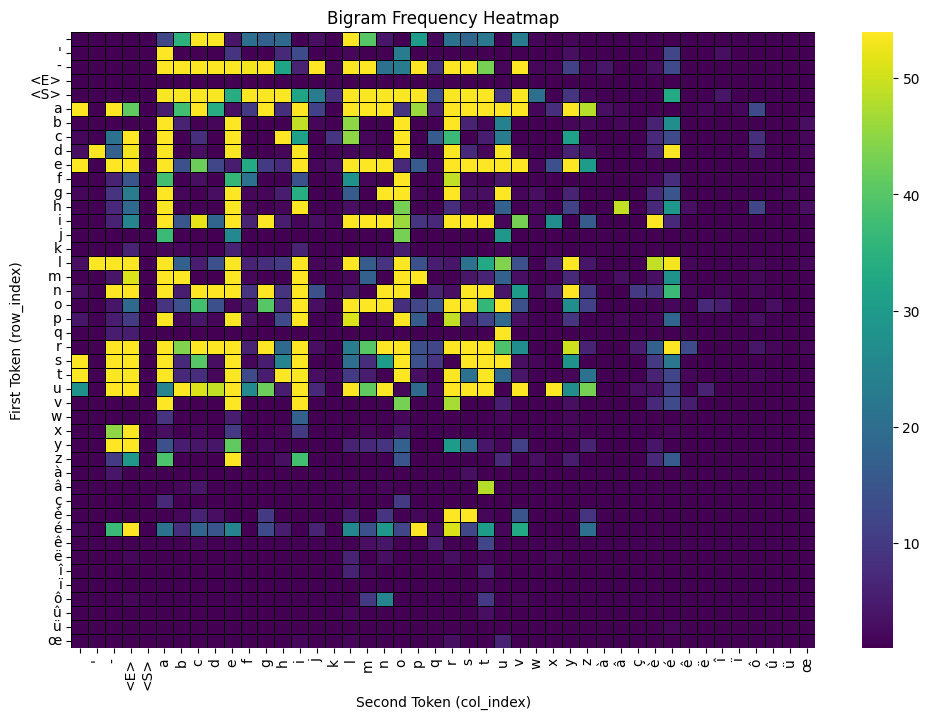

In [136]:
plt.figure(figsize=(12, 8)) # Set the size of the plot for better readability
sns.heatmap(N,
            cmap='viridis', # Color map: 'Blues' for light to dark blue, 'viridis' or 'magma' are also good
            linewidths=.5, # Adds lines between cells
            vmin=1,        # Often good to start from 1 if N was initialized with ones
            vmax=np.percentile(N.flatten(), 90), # Use the calculated (or manually set) vmax
            linecolor='black', # Color of the lines
            xticklabels=[int2token[i] for i in range(vocab_size)], # X-axis labels (columns)
            yticklabels=[int2token[i] for i in range(vocab_size)]  # Y-axis labels (rows)
           )
plt.title('Bigram Frequency Heatmap') # Title of the plot
plt.xlabel('Second Token (col_index)') # Label for the X-axis
plt.ylabel('First Token (row_index)') # Label for the Y-axis
plt.show() # Display the plot

In [137]:
# Convert the matrix to float type first, as probabilities will be decimal numbers
P = N.astype(float)

# Calculate the sum of each row (axis=1) and keep dimensions for proper broadcasting
row_sums = P.sum(axis=1, keepdims=True)

# Divide each element in P by its corresponding row sum
P = P / row_sums

print("\n--- Bigram Probability Matrix 'P' ---")
print(f"Matrix 'P' after calculating probabilities (shape: {P.shape}):")
print(P[:5, :5]) # Print top-left 5x5 corner of the probability matrix

# Verify that rows sum to 1 (or very close, due to floating point precision)
print("\nFirst 5 row sums of probability matrix P (should be close to 1.0):")
print(P.sum(axis=1)[:5])


--- Bigram Probability Matrix 'P' ---
Matrix 'P' after calculating probabilities (shape: (44, 44)):
[[0.00180832 0.00180832 0.00180832 0.00180832 0.00180832]
 [0.00591716 0.00591716 0.00591716 0.00591716 0.00591716]
 [0.0004207  0.0004207  0.0004207  0.0004207  0.0004207 ]
 [0.02272727 0.02272727 0.02272727 0.02272727 0.02272727]
 [0.00028377 0.00028377 0.00028377 0.00028377 0.00028377]]

First 5 row sums of probability matrix P (should be close to 1.0):
[1. 1. 1. 1. 1.]


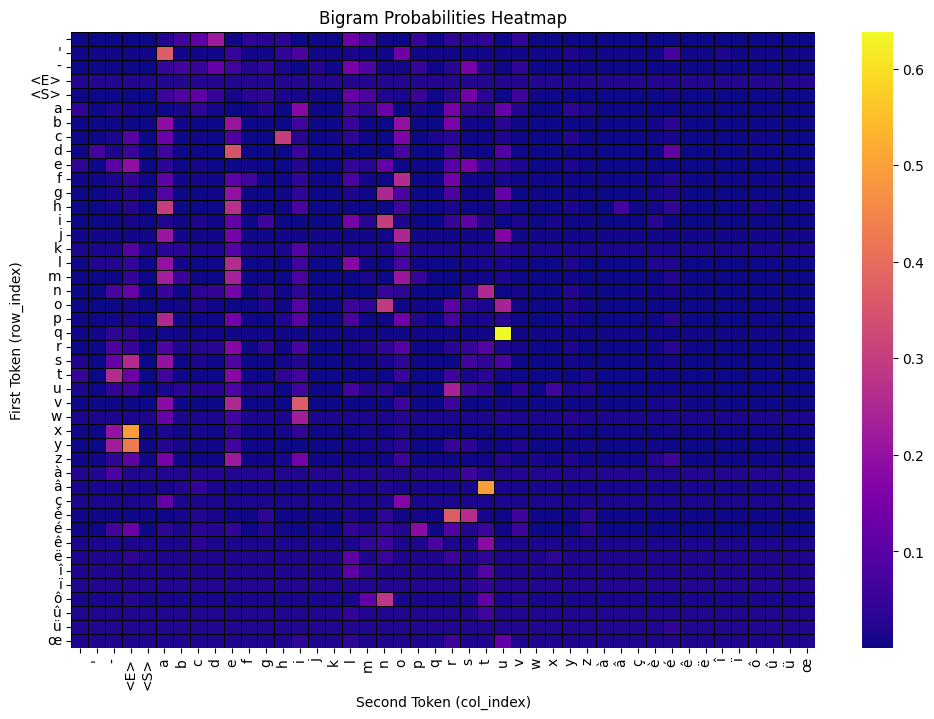

In [138]:
plt.figure(figsize=(12, 8)) # Set the size of the plot for better readability
sns.heatmap(P,
            cmap='plasma', # Color map: 'Blues' for light to dark blue, 'viridis' or 'magma' are also good
            linewidths=.5, # Adds lines between cells
            linecolor='black', # Color of the lines
            xticklabels=[int2token[i] for i in range(vocab_size)], # X-axis labels (columns)
            yticklabels=[int2token[i] for i in range(vocab_size)]  # Y-axis labels (rows)
           )
plt.title('Bigram Probabilities Heatmap') # Title of the plot
plt.xlabel('Second Token (col_index)') # Label for the X-axis
plt.ylabel('First Token (row_index)') # Label for the Y-axis
plt.show() # Display the plot

In [139]:
# Set the random seed for reproducibility (NumPy equivalent of torch.Generator().manual_seed)
np.random.seed(2147483647) # Using the same seed as your torch example

# Get the integer IDs for our special tokens
# Note: '<E>' will typically have index 0 if sorted alphabetically, '<S>' will have index 1 (or higher)
start_token_idx = token2int['<S>']
end_token_idx = token2int['<E>']

print("\n--- Generated Sequences ---")
for i in range(5): # Generate 5 sequences as in your example
    out = []
    ix = start_token_idx # Start with the index of the '<S>' token

    while True:
        # Get the probability distribution for the current token 'ix'
        p_distribution = P[ix]

        # Sample the next token's index based on the probabilities
        # np.random.choice(a, size=1, p=probabilities)
        # a: The range of possible indices (0 to vocab_size-1)
        # size: How many samples to draw (we want 1)
        # p: The probabilities for each choice
        next_ix = np.random.choice(vocab_size, size=1, p=p_distribution).item() # .item() extracts the scalar from the array

        # If the sampled token is the end token, break the loop
        if next_ix == end_token_idx:
            break

        # Append the actual character/token (using int2token) to our output list
        out.append(int2token[next_ix])

        # Set the current index to the newly sampled index for the next iteration
        ix = next_ix

    # Join the generated characters to form a string and print
    print(''.join(out))


--- Generated Sequences ---
hievioièran
sa ffoceure-baulle-as
s
drecotesonogarse-rn
gr-mazparçausenese


In [140]:
log_ll = 0.0
n = 0

# Iterate over each list of tokens (representing a unique toponym)
for tokens in unique_toponym_token_lists:
    # Iterate over pairs of adjacent tokens in the current list
    # 'tokens[:-1]' gets all tokens except the last one (the first token of the pair)
    # 'tokens[1:]' gets all tokens except the first one (the second token of the pair)
    for token1, token2 in zip(tokens[:-1], tokens[1:]):
        # Get the integer IDs for the current pair of tokens
        ix1 = token2int[token1]
        ix2 = token2int[token2]

        prob = P[ix1, ix2] # Look up the probability of ch2 following ch1 from your P matrix
        logprob = np.log(prob) # Calculate the logarithm of this probability
        log_ll += logprob # Sum up all log probabilities

        n += 1 # Count the total number of bigrams processed


print(f'{log_ll=}')
nll = -log_ll # Calculate Negative Log-Likelihood (NLL)
print(f'{nll=}')
print(f'{nll/n}') # Calculate Average Negative Log-Likelihood


log_ll=np.float64(-106441.43233610045)
nll=np.float64(106441.43233610045)
2.424468312782736


In [141]:
X, Y = [], []
for tokens in unique_toponym_token_lists:
    # Iterate over pairs of adjacent tokens (bigrams)
    for ch1, ch2 in zip(tokens[:-1], tokens[1:]):
        # Get the integer indices for the current bigram
        ix1 = token2int[ch1]
        ix2 = token2int[ch2]
        X.append(ix1) # Add the first character's index to inputs
        Y.append(ix2) # Add the second character's index to targets

# Convert lists to NumPy arrays
X = np.array(X)
Y = np.array(Y)

num_examples = X.size # Total number of bigram examples in our dataset
print(f"\n--- Neural Network Training Data Setup ---")
print(f"Number of bigram examples: {num_examples}")
print(f"Example input indices (xs[:5]): {X[:5]}")
print(f"Example target indices (ys[:5]): {Y[:5]}")

# One-hot encode the input characters (xs)
# This converts each integer index into a vector of 0s and a single 1.
# The '1' is at the position corresponding to the character's index.
xenc = np.zeros((num_examples, vocab_size)) # Initialize a matrix of zeros
for i, ix in enumerate(X):
    xenc[i, ix] = 1.0 # Set the appropriate position to 1.0

print(f"\nOne-hot encoded inputs (xenc.shape): {xenc.shape}")
print("Example of one-hot encoding (first row):")
print(xenc[0, :]) # Shows the one-hot encoding for the first input character


--- Neural Network Training Data Setup ---
Number of bigram examples: 43903
Example input indices (xs[:5]): [ 4 10 22  5 18]
Example target indices (ys[:5]): [10 22  5 18  7]

One-hot encoded inputs (xenc.shape): (43903, 44)
Example of one-hot encoding (first row):
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [142]:
# Randomly initialize the 'weights' of our neural network.
# This 'W' matrix will be the learnable parameter of our model,
# analogous to bigram count matrix N, but it will be adjusted.
# Its dimensions are (vocab_size, vocab_size) because for each of the
# 'vocab_size' possible input characters, we want to predict 'vocab_size'
# scores for the next character.
g_nn = np.random.default_rng(2147483647) # NumPy random generator for reproducibility
W = g_nn.random((vocab_size, vocab_size)) # Initialize W with random values

print(f"\n--- Simple Neural Network Setup ---")
print(f"Initial 'Weight' Matrix W (shape: {W.shape}):")
print(W[:5, :5]) # Display a small portion

# Forward pass: Calculate 'logits'
# This is the core operation: input (xenc) multiplied by weights (W).
# It produces raw, unnormalized scores for each possible next character.
logits = xenc @ W # Matrix multiplication: (num_examples, vocab_size) @ (vocab_size, vocab_size) -> (num_examples, vocab_size)

print(f"\nCalculated Logits (shape: {logits.shape}):")
print(logits[:5, :5]) # Display a small portion

# Apply the Softmax function to convert logits into probabilities
# 1. Exponentiate logits to get 'counts' (ensure positivity)
counts = np.exp(logits)

# 2. Normalize by summing across rows to get probabilities that sum to 1
probs = counts / counts.sum(axis=1, keepdims=True)

print(f"\nCalculated Probabilities (probs.shape): {probs.shape}")
print(probs[:5, :5]) # Display a small portion
print("First 5 row sums of probabilities (should be close to 1.0):")
print(probs.sum(axis=1)[:5])


--- Simple Neural Network Setup ---
Initial 'Weight' Matrix W (shape: (44, 44)):
[[0.2708541  0.93389945 0.43941767 0.64447737 0.49724201]
 [0.13877742 0.23388398 0.94063547 0.02304841 0.66471749]
 [0.61984818 0.53487395 0.59330382 0.79357598 0.59732323]
 [0.988035   0.65412574 0.80652753 0.58799818 0.00539915]
 [0.5521667  0.51823349 0.96534974 0.64553891 0.05829891]]

Calculated Logits (shape: (43903, 44)):
[[0.5521667  0.51823349 0.96534974 0.64553891 0.05829891]
 [0.34907077 0.91891634 0.26184254 0.26361617 0.15630584]
 [0.32535051 0.59934736 0.39627999 0.19616441 0.94929165]
 [0.40541968 0.05648391 0.76309273 0.1310019  0.21122658]
 [0.39909808 0.57550875 0.13406015 0.19706231 0.65089807]]

Calculated Probabilities (probs.shape): (43903, 44)
[[0.02224224 0.02150015 0.03362186 0.0244191  0.01357358]
 [0.01912432 0.03381169 0.01752683 0.01755794 0.01577137]
 [0.0193186  0.02540803 0.02073863 0.01697739 0.0360537 ]
 [0.02035507 0.01435925 0.02910772 0.01547015 0.01676238]
 [0.020715

In [143]:
# Calculate the Negative Log-Likelihood (Loss)
# This measures how well our current 'W' matrix predicts the actual next characters (ys).

# 1. Get the probabilities that the network assigned to the *correct* next characters.
#    This selects probs[example_idx, target_char_idx] for each example.
correct_char_probs = probs[np.arange(num_examples), Y]

# 2. Calculate the log of these probabilities.
#    We use np.log to get the log-likelihood for each correct prediction.
log_likelihood_per_example = np.log(correct_char_probs)

# 3. Calculate the average negative log-likelihood.
#    This is our loss: we want to minimize this value during training.
loss = -log_likelihood_per_example.mean()

print(f"\n--- Loss Calculation ---")
print(f"Average Negative Log-Likelihood (Loss) with current W: {loss:.4f}")


--- Loss Calculation ---
Average Negative Log-Likelihood (Loss) with current W: 3.8240


In [144]:
# --- Initialize Neural Network Weights (W) ---
# Use a reproducible random generator for weights
rng = np.random.default_rng(2147483647)
W = rng.random((vocab_size, vocab_size)) # Initialize W with random values

print(f"\nInitial 'Weight' Matrix W (shape: {W.shape}):")
print(W[:5, :5])

# --- Training Loop (Gradient Descent in NumPy) ---
learning_rate = 0.01 # This learning rate might need tuning for your data
num_epochs = 10_000    # Number of training iterations



Initial 'Weight' Matrix W (shape: (44, 44)):
[[0.2708541  0.93389945 0.43941767 0.64447737 0.49724201]
 [0.13877742 0.23388398 0.94063547 0.02304841 0.66471749]
 [0.61984818 0.53487395 0.59330382 0.79357598 0.59732323]
 [0.988035   0.65412574 0.80652753 0.58799818 0.00539915]
 [0.5521667  0.51823349 0.96534974 0.64553891 0.05829891]]


In [145]:
print(f"\n--- Starting Training Loop ({num_epochs} epochs) ---")

for k in range(num_epochs):
    # --- Forward Pass ---
    # 1. One-hot encode the input characters (xs)
    #    xenc: (num_examples, vocab_size)
    xenc = np.zeros((num_examples, vocab_size))
    xenc[np.arange(num_examples), X] = 1.0

    # 2. Calculate logits (raw scores)
    #    logits = xenc @ W (matrix multiplication)
    #    logits: (num_examples, vocab_size)
    logits = xenc @ W

    # 3. Apply Softmax to convert logits to probabilities
    #    counts: (num_examples, vocab_size) - exponentiated logits
    counts = np.exp(logits)
    #    probs: (num_examples, vocab_size) - probabilities that sum to 1 across each row
    probs = counts / counts.sum(axis=1, keepdims=True)

    # 4. Calculate Loss (Average Negative Log-Likelihood)
    #    Select probabilities assigned to the *correct* next characters (ys)
    correct_char_probs = probs[np.arange(num_examples), Y]
    #    Calculate log likelihood for these correct probabilities
    log_likelihood_per_example = np.log(correct_char_probs)
    #    Calculate average negative log-likelihood (loss)
    loss = -log_likelihood_per_example.mean()

    # Add L2 regularization to the loss
    # Penalizes large weights to prevent overfitting
    regularization_strength = 0.01
    loss += regularization_strength * np.mean(W**2)

    # --- Backward Pass (Manual Gradient Calculation) ---
    # The gradient of the Softmax Cross-Entropy loss with respect to logits is:
    # dL/d(logits) = probs - one_hot_encoded_targets
    # First, create one-hot encoded targets for ys
    one_hot_ys = np.zeros((num_examples, vocab_size))
    one_hot_ys[np.arange(num_examples), Y] = 1.0

    # Calculate the gradient of loss w.r.t. logits
    dlogits = probs - one_hot_ys # (num_examples, vocab_size)

    # Calculate the gradient of loss w.r.t. W
    # dL/dW = xenc.T @ dL/d(logits)
    # dW: (vocab_size, vocab_size)
    dW = xenc.T @ dlogits

    # Add gradient for regularization term
    dW += 2 * regularization_strength * W # Derivative of (W^2).mean() is 2*W.mean()

    # --- Update Weights (Gradient Descent Step) ---
    W -= learning_rate * dW # Move W in the direction opposite to the gradient

    if k % 100 == 0 or k == num_epochs - 1: # Print loss periodically
        print(f"Epoch {k}/{num_epochs-1}, Loss: {loss:.4f}")

print("\n--- Training Complete ---")



--- Starting Training Loop (10000 epochs) ---
Epoch 0/9999, Loss: 3.8274
Epoch 100/9999, Loss: 5.6661
Epoch 200/9999, Loss: 4.3670
Epoch 300/9999, Loss: 5.5752
Epoch 400/9999, Loss: 4.7821
Epoch 500/9999, Loss: 5.6062
Epoch 600/9999, Loss: 5.0159
Epoch 700/9999, Loss: 3.8666
Epoch 800/9999, Loss: 5.3192
Epoch 900/9999, Loss: 5.5474
Epoch 1000/9999, Loss: 5.2769
Epoch 1100/9999, Loss: 5.4937
Epoch 1200/9999, Loss: 5.1385
Epoch 1300/9999, Loss: 6.1013
Epoch 1400/9999, Loss: 4.5810
Epoch 1500/9999, Loss: 4.9477
Epoch 1600/9999, Loss: 4.7510
Epoch 1700/9999, Loss: 5.1451
Epoch 1800/9999, Loss: 5.0538
Epoch 1900/9999, Loss: 5.4214
Epoch 2000/9999, Loss: 4.6812
Epoch 2100/9999, Loss: 4.8693
Epoch 2200/9999, Loss: 4.6826
Epoch 2300/9999, Loss: 5.2765
Epoch 2400/9999, Loss: 5.4612
Epoch 2500/9999, Loss: 4.9055
Epoch 2600/9999, Loss: 4.8386
Epoch 2700/9999, Loss: 6.0092
Epoch 2800/9999, Loss: 5.9804
Epoch 2900/9999, Loss: 5.0352
Epoch 3000/9999, Loss: 4.7710
Epoch 3100/9999, Loss: 5.1934
Epoch

In [146]:

# --- Final Sampling from the Trained Neural Network Model ---
print("\n--- Generated Sequences from Trained Model ---")
# Use the same random generator for sampling for reproducibility
g_sampling = np.random.default_rng(2147483647) # Using the same seed as torch example

start_token_idx = token2int['<S>']
end_token_idx = token2int['<E>']

for i in range(5): # Generate 5 sequences
    out = []
    ix = start_token_idx # Start with the index of the '<S>' token

    while True:
        # Perform a forward pass through the (now trained) neural network
        # to get the probability distribution for the next character.
        # Create a one-hot encoding for the current single input token
        xenc_single = np.zeros((1, vocab_size))
        xenc_single[0, ix] = 1.0

        logits_single = xenc_single @ W
        counts_single = np.exp(logits_single)
        p_distribution = counts_single / counts_single.sum(axis=1, keepdims=True)

        # Sample the next token's index based on the probabilities
        next_ix = g_sampling.choice(vocab_size, size=1, p=p_distribution[0]).item()

        # If the sampled token is the end token, break the loop
        if next_ix == end_token_idx:
            break

        # Append the actual character/token (using int2token) to our output list
        out.append(int2token[next_ix])

        # Set the current index to the newly sampled index for the next iteration
        ix = next_ix

    # Join the generated characters to form a string and print
    print(''.join(out))


--- Generated Sequences from Trained Model ---
cuiles-vis-les-dècouresux
mas-les-lalalalay-cay-la-pales-diles-letacoufay
res-bouzis-les-les-les-les-bouyrces-vilates-fcc
bomala-laméppl-lala bsun
balap-les-magnes-les-lay
